# 03-202 : Question 5 Model

Train a model specifically for question 5, and then use it in conjunction with `simple_monkey` to predict the entire dataset and get a classification report.

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of distutils.errors failed: Traceback (most recent call last):
  File "/root/miniconda3/envs/pycaret/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/root/miniconda3/envs/pycaret/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "/root/miniconda3/envs/pycaret/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/root/miniconda3/envs/pycaret/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 361, in update_class
    update_instances(old, new)
  File "/root/miniconda3/envs/pycaret/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 315, in update_instances
    refs = gc.get_referrers(old)
KeyboardInterrupt
]


In [ ]:
import sys
import logging
from typing import Tuple

import pandas as pd
import mlflow

import tensorflow_addons as tfa
import keras as k
from keras import optimizers
import keras_tuner
import keras_tuner as kt

from competition import data_preparation as dp
from competition import feature_engineering as fe
from competition import model_data as md
from competition import source_data as sd
import competition.models.simple_dense as sd_model
from competition.models.heatmap_covnet import HeatmapCovnetModel

### Configure Logging

In [ ]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[
        logging.StreamHandler(sys.stdout)
    ])

logging.info("Started")

2023-04-01 22:23:27 INFO     Started


## Data Collection

In [ ]:
# load the source training set
df_source = sd.read_csv('../data/train.csv.gz',
                        compression='gzip',
                        dtype=sd.source_dtype)

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [ ]:
# load the source training labels
df_source_labels = sd.read_csv('../data/train_labels.csv')

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Data Preparation & Cleaning

In [ ]:
# prepare the main dataset
df_source = dp.prepare_main_dataset(df_source,
                                    elapsed_time_min_clip=0,
                                    elapsed_time_max_clip=3691298)

# remove sessions with problems
problem_sessions = dp.find_problem_sessions(df_source)
df_source = df_source[~df_source['session_id'].isin(problem_sessions)]

In [ ]:
# prepare the label dataset
df_source_labels = dp.prepare_label_dataset(df_source_labels)

# remove sessions with problems
df_source_labels = df_source_labels[~df_source_labels['session_id'].isin(problem_sessions)]

## Feature Engineering

Instead of duplicating the feature engineering workflow, we will use the same feature dataset created in notebook `03-123`.

In [ ]:
df_features = pd.read_pickle(
    'data/features/03-123.parquet',
    compression='gzip')

with pd.option_context('display.max_columns', None):
    display(df_features.head(3))

,session_id,level_group,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode,count_total_event_name,count_total_name,count_total_fqid,count_total_room_fqid,count_total_text_fqid,count_unique_event_name,count_unique_name,count_unique_fqid,count_unique_room_fqid,count_unique_text_fqid,screen_heatmap_feature
0,20090312431273200,0-4,0.001411,0.052535,0.000000,0.023103,0.000000,0.088782,0.088782,0.064620,0.088782,0.054054,0.75,0.0,0.203390,0.090909,0.225,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,20090312431273200,13-22,0.043740,0.344602,0.226677,0.281804,0.301320,0.394721,0.394721,0.402262,0.394721,0.480127,0.75,0.0,0.525424,0.545455,0.675,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,20090312431273200,5-12,0.010577,0.135014,0.060002,0.096641,0.060002,0.245951,0.245951,0.276252,0.245951,0.257552,0.75,0.0,0.355932,0.454545,0.400,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


## Data Selection

We first combine the features with the labels as we will do data selection now based on question number as opposed to to all previous notebooks.

In [ ]:
df_combined = df_source_labels.merge(
    right=df_features, 
    on=['session_id', 'level_group'],
    how='left')

print(df_combined.shape)
with pd.option_context('display.max_columns', None):
    display(df_combined.head(6))

(209664, 20)


,session_id,question_num,correct,level_group,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode,count_total_event_name,count_total_name,count_total_fqid,count_total_room_fqid,count_total_text_fqid,count_unique_event_name,count_unique_name,count_unique_fqid,count_unique_room_fqid,count_unique_text_fqid,screen_heatmap_feature
0,20090312431273200,1,1,0-4,0.001411,0.052535,0.0,0.023103,0.0,0.088782,0.088782,0.064620,0.088782,0.054054,0.75,0.000000,0.203390,0.090909,0.225,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,20090312433251036,1,0,0-4,0.001352,0.063074,0.0,0.026311,0.0,0.057588,0.057588,0.053312,0.057588,0.050874,1.00,0.333333,0.067797,0.000000,0.075,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,20090314121766812,1,1,0-4,0.002928,0.106324,0.0,0.047996,0.0,0.088782,0.088782,0.066236,0.088782,0.044515,1.00,0.333333,0.135593,0.090909,0.175,"[[[0.05882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
3,20090314363702160,1,1,0-4,0.001627,0.058690,0.0,0.030143,0.0,0.065987,0.065987,0.050081,0.065987,0.034976,0.50,0.000000,0.050847,0.090909,0.075,"[[[0.05882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
4,20090314441803444,1,1,0-4,0.000824,0.047682,0.0,0.020862,0.0,0.019196,0.019196,0.025848,0.019196,0.022258,0.50,0.000000,0.067797,0.090909,0.050,"[[[0.05882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
5,20090315081004164,1,0,0-4,0.002515,0.092231,0.0,0.036151,0.0,0.116377,0.116377,0.096931,0.116377,0.063593,0.75,0.000000,0.118644,0.090909,0.150,"[[[0.05882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."


Create a function that will combine the datasets like we just did above and then return the dataset for the specified question.

In [ ]:
def get_question_dataset(features: pd.DataFrame,
                         labels: pd.DataFrame,
                         question_num: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns a dataset containing only the specified question_num.

    Parameters
    ----------
    features : pd.DataFrame
        The features dataset with prepared and normalized data.
    labels : pd.DataFrame
        The labels dataset containing the target variable.
    question_num : int
        The question number to filter on.

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame]
        The filtered features and labels datasets.
    """
    # combine the features and labels datasets
    df_combined = labels.merge(
        right=features, 
        on=['session_id', 'level_group'],
        how='left')

    # filter the combined dataset on the specified question_num
    df_question = df_combined[df_combined['question_num'] == question_num]

    # convert the "heatmap" column to a list
    screen_heatmap_feature = pd.DataFrame()
    if 'screen_heatmap_feature' in df_question.columns:
        screen_heatmap_feature = df_question['screen_heatmap_feature']

    # split the combined dataset into features and labels again
    df_question_features = df_question \
        .drop(columns=['question_num', 'correct', 'screen_heatmap_feature']) \
        .drop_duplicates()
    
    # add the heatmap feature to df_question_features
    if 'screen_heatmap_feature' in df_question.columns:
        df_question_features.join(screen_heatmap_feature, how='left')

    df_question_labels = df_question[['session_id', 'question_num', 
                                     'correct', 'level_group']]        
    
    # return the filtered features and labels datasets
    return df_question_features, df_question_labels

# test the function
df_question_features, df_question_labels = get_question_dataset(features=df_features,
                                                                labels=df_source_labels,
                                                                question_num=5)

Split the data into training and test sets.

In [ ]:
random_state = 51

In [ ]:
# split the dataset into train, validation and test sets
train, val, test = md.select_sessions(
    y=df_question_labels,
    random_state=random_state,
    test_size=0.60,
    train_size=0.75)

Train: 3495
Validation: 1165
Test: 6988


## Model Training

### Create Datasets

In [ ]:
# set the feature list
feature_list = ['elapsed_time_sum', 'elapsed_time_max', 'elapsed_time_min', 'elapsed_time_mean', 'elapsed_time_mode']

# create the simple model dataset
features_dataset = md.get_feature_dataset(
    features=df_question_features,
    y=df_question_labels,
    feature_list=feature_list,
    train=train,
    val=val,
    test=test,
    include_question=True,
    expand_question=False)

2023-04-01 22:24:08 INFO     -- Creating the train dataset
2023-04-01 22:24:08 INFO     Creating the dataset for all level groups


  0%|          | 0/3495 [00:00<?, ?it/s]

2023-04-01 22:24:14 INFO     -- Creating the val dataset
2023-04-01 22:24:14 INFO     Creating the dataset for all level groups


  0%|          | 0/1165 [00:00<?, ?it/s]

2023-04-01 22:24:15 INFO     -- Creating the test dataset
2023-04-01 22:24:15 INFO     Creating the dataset for all level groups


  0%|          | 0/6988 [00:00<?, ?it/s]

In [ ]:
# convert the labels for multi-label classification
cat_features_dataset = md.labels_to_categorical(features_dataset)

In [ ]:
# get the shape of the question only dataset
input_data = cat_features_dataset['train']['X']
features_dataset_shape = input_data.shape[1]
print('features_dataset_shape:', features_dataset_shape)

# define the output shape
output_data = cat_features_dataset['train']['y']
output_shape = output_data.shape[1]
print('output_shape', output_shape)

features_dataset_shape: 23
output_shape 2


### Flat Features Only

In [ ]:
# configure mlflow
mlflow.set_experiment("question-05-simple")
mlflow.keras.autolog()

Trial 48 Complete [00h 00m 10s]
val_f1_score: 0.35061317682266235

Best val_f1_score So Far: 0.6657218933105469
Total elapsed time: 00h 11m 31s
2023-04-01 22:36:03 INFO     on_trial_begin

Search: Running Trial #49

Value             |Best Value So Far |Hyperparameter
19                |17                |dense_layer_count
672               |512               |dense_units
tanh              |tanh              |dense_activation
0.00029           |0.00036           |dense_l1_regularization
0.0005            |0.0003            |dense_l2_regularization
0.055             |0.09              |dense_dropout
0.0001            |0.001             |learning_rate

2023-04-01 22:36:03 INFO     Creating simple dense model
Epoch 1/2000
1/1 [==============================] - 1s 1s/step - loss: 85.6996 - f1_score: 0.4208 - val_loss: 85.4422 - val_f1_score: 0.3506
Epoch 2/2000
1/1 [==============================] - 0s 158ms/step - loss: 85.4406 - f1_score: 0.3652 - val_loss: 85.1885 - val_f1_score: 0.3633

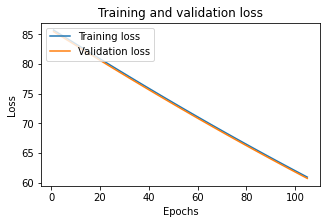

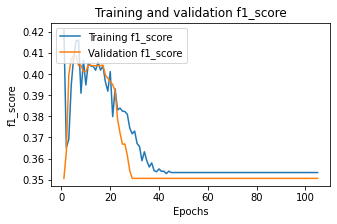

146/146 [==============================] - 0s 885us/step


#### Threshold: 0.5
```
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00      3157
         1.0       0.55      1.00      0.71      3831

    accuracy                           0.55      6988
   macro avg       0.77      0.50      0.35      6988
weighted avg       0.75      0.55      0.39      6988

```

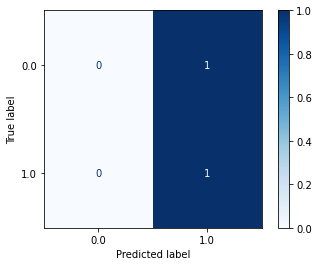

#### Optimal Threshold: 0.00
```
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00      3157
         1.0       0.55      1.00      0.71      3831

    accuracy                           0.55      6988
   macro avg       0.77      0.50      0.35      6988
weighted avg       0.75      0.55      0.39      6988

```

KeyboardInterrupt: 

In [ ]:
# create the hyperparameter object
def define_tune_parameters(hp):
    hp.Int('dense_layer_count', min_value=1, max_value=20, step=1)
    hp.Int('dense_units', min_value=512, max_value=1700, step=32)
    hp.Choice('dense_activation', values=['relu', 'tanh', 'LeakyReLU'])
    hp.Float('dense_l1_regularization', min_value=0.0, max_value=0.0005, step=0.00001)
    hp.Float('dense_l2_regularization', min_value=0.0, max_value=0.001, step=0.0001)
    hp.Float('dense_dropout', min_value=0.005, max_value=0.1, step=0.005)
    hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5])

# find the best model
model = sd_model.tune_model(
    define_tune_parameters=define_tune_parameters,
    dataset=cat_features_dataset,
    max_trials=1000,
    input_shape=features_dataset_shape,
    output_shape=output_shape,
    dense_layer_count='dense_layer_count',
    dense_units='dense_units',
    dense_activation='dense_activation',
    dense_l1_regularization='dense_l1_regularization',
    dense_l2_regularization='dense_l2_regularization',
    dense_dropout='dense_dropout',
    train_epochs=2000,
    train_batch_size=4000,
    train_optimizer=optimizers.Adam,
    train_learning_rate='learning_rate',
    train_loss='categorical_crossentropy',
    train_metrics=[tfa.metrics.F1Score(name='f1_score', num_classes=2, threshold=0.5, average='macro')],
    train_class_weight=None,
    tune_objective='val_f1_score',
    tune_direction='max',
    tuner_type=kt.tuners.RandomSearch)

model.summary()